In [1]:
import torch
import torchvision
import torch.nn as nn                                                
import torch.nn.functional as F
import torch.optim as optim
torch.set_printoptions(linewidth = 120)
torch.set_grad_enabled(True)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import matplotlib.pyplot as plt

import numpy as np
from PIL import Image 
from IPython.display import clear_output
from torchvision.transforms import ToTensor

from numpy import random 
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from torch.optim.lr_scheduler import StepLR

In [2]:
x_train = np.array(np.load("numpy/x_train.npy"))

print(x_train.shape)

(86989, 3, 32, 32)


In [3]:
y_train = np.array(np.load("numpy/y_train.npy"))

print(y_train.shape)

(86989,)


In [4]:
x_test = np.array(np.load("numpy/x_test.npy"))
y_test = np.array(np.load("numpy/y_test.npy"))

print(x_test.shape)
print(y_test.shape)

(12630, 3, 32, 32)
(12630,)


In [6]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)       ## make compatible with DataLoader 

x_test_tensor = torch.from_numpy(x_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)       ## make compatible with DataLoader 


In [36]:
##### 43 labels 

train_loader = DataLoader(dataset=train_dataset, batch_size=28, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle = True)

print(len(train_loader))
print(len(val_loader))

3107
3158


In [9]:

def vis_loss_multi(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=7)
    plt.plot( ysmoothed, label = "training loss")
    
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=18)
    plt.plot(ysmoothed2, label = "validation loss")
    plt.show()
    

def vis_loss_multi_colors(loss_arr,val_arr):
    
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")

    plt.show()
    

def save_nn(filename):

    torch.save(trafficnet, filename)
    print (" saved -- ", filename )      

In [37]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
                
        
        self.conv1 = nn.Conv2d(3, 45, 3)           
        
        self.pool = nn.MaxPool2d(3,3)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.conv2 = nn.Conv2d(45,90,3)
        self.conv3 = nn.Conv2d(90,150,3) 
        
        self.conv4 = nn.Conv2d(150,200,3)

        self.fc1 = nn.Linear(3200, 1200)   # linear layers   
        self.fc2 = nn.Linear(1200, 430)
        
        self.fc3 = nn.Linear(430, 43)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
                                                                       
        x = self.dropout(self.pool(x))
 
        x = F.relu(self.conv2(x))
        x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
    
        x = x.view(x.size(0), -1)        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x =F.relu(self.fc2(x))
        x = self.fc3(x)
   
        return x

trafficnet = Net()
print(trafficnet)
net = trafficnet

Net(
  (conv1): Conv2d(3, 45, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(45, 90, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(90, 150, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=430, bias=True)
  (fc3): Linear(in_features=430, out_features=43, bias=True)
)


In [38]:
losses = []
val_losses = []

avg_losses = []
avg_val_losses = []


## metrics 

In [39]:
def make_train_step(model, optimizer):

    def train_step(x, y):
     
        pred = model(x)       
        y = y.long()
        loss = F.cross_entropy(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        optimizer.zero_grad()
        
        print ("|", end = "")
        return loss.item()
      
    return train_step

model = trafficnet

optimizer = optim.SGD(trafficnet.parameters(), learning_rate) 

train_step = make_train_step(model, optimizer)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)  # lr decreases by 10% aftr every epoch

train_valve = False

def train_trafficnet(train_loader, epochs, initial_lr):
    learning_rate = initial_lr
 
    train_valve = False

    for i in range(epochs):

        foo = optimizer.param_groups[0]['lr']

        print("training batches  --", end = "")

        for x_batch, y_batch in train_loader:

            model.train()

            loss = train_step(x_batch, y_batch)

            losses.append(loss)  ## metrics 

        with torch.no_grad():
            for x_val, y_val in val_loader:

                model.eval()

                y_val = y_val.long()

                yhat = model(x_val)  # pred 
                val_loss = F.cross_entropy(yhat, y_val)

                val_losses.append(val_loss.item())  ## metrics 

        scheduler.step()   ## lr decay caller 
        clear_output()

        epoch_avg_loss = sum(losses[-3107:])/3107

        val_av_loss = sum(val_losses[-3158:])/3158

        avg_losses.append(epoch_avg_loss)

        avg_val_losses.append(val_av_loss)

        vis_loss_multi(losses, val_losses)

        print("recent state in the last 500 batches -- ")
        vis_loss_multi_colors(losses[-500:], val_losses[-500:])

        print ("epoch - ", i+1, "  current lr = ", foo,  " epoch_avg_loss = ", epoch_avg_loss, "  validation_average_loss = ", val_av_loss)

        if val_av_loss < 0.388:

            train_valve = True
            print ("train valve set to true")

        if train_valve == True and val_av_loss>0.388:
            print ("prevented  overfit ----")
            break
        
        if i != 0:
            
            if val_av_loss < avg_val_losses[-2]:

                print (val_av_loss, "  <  ",avg_val_losses[-2] )

                save_nn("torch/checker.pth")
    

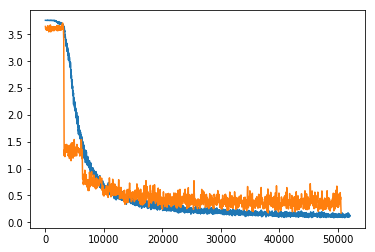

recent state in the last 500 batches -- 


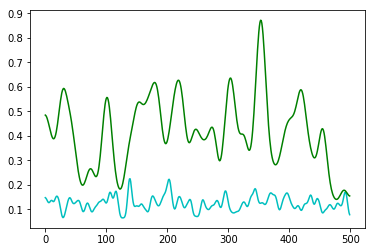

epoch -  1   current lr =  0.0018530201888518414  epoch_avg_loss =  0.12283389517374392   validation_average_loss =  0.37248896720133484
train valve set to true


In [42]:
train_trafficnet(train_loader, 1, initial_lr = 0.05) 

